# Crossover analysis for Evolutionary Algorithms

In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from alg import *
from utils import *

In [2]:
num_trials = 3
pop_size = 50
max_iters = 200
resources = [*range(1, 10), *range(10, 25, 5)]

def three_point_crossover(x, y):
    return npoint_crossover(x, y, n=3)

crossovers = [one_point_crossover, two_point_crossover, three_point_crossover, uniform_crossover]

def eval_lpt(R, get_instance):
    _, m, r, = lpt(R, p=get_instance(R))
    return m / r, m

def makespan(R, p, xover):
    _, m = evolve(
        R=R,
        p=p,
        mate=xover,
        mutate=mutation(vec_tweak, R),
        pop_size=pop_size,
        max_iters=max_iters,
        penalize=False,
    )
    return m

def evaluate(xover, get_instance, verbose=True):
    for R in resources:
        yield sum(makespan(R, get_instance(R), xover) for _ in range(num_trials)) / num_trials
        if verbose:
            print(f'DONE xover={xover.__name__} R={R}')
    if verbose:
        print(f'DONE xover={xover.__name__}')

## Comparison on SAMPLE_INSTANCE

In [3]:
def sample_instance(_):
    return SAMPLE_INSTANCE

<AxesSubplot:title={'center':'LPT on SAMPLE_INSTANCE'}, xlabel='#resources', ylabel='min. makespan'>

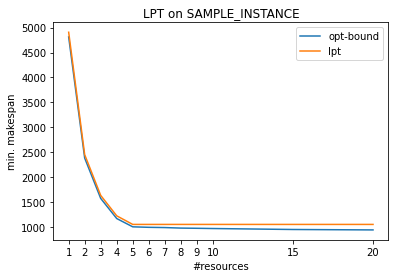

In [4]:
lpt_df = pd.DataFrame(data=(eval_lpt(R, sample_instance) for R in resources), index=resources, columns=['opt-bound', 'lpt'])
lpt_df.plot.line(xticks=resources, xlabel='#resources', ylabel='min. makespan', title='LPT on SAMPLE_INSTANCE')

In [5]:
ea_df = pd.DataFrame({xover.__name__: evaluate(xover, sample_instance) for xover in crossovers}, index=resources)
ea_df = pd.concat([lpt_df, ea_df], axis=1)

DONE xover=one_point_crossover R=1
DONE xover=one_point_crossover R=2
DONE xover=one_point_crossover R=3
DONE xover=one_point_crossover R=4
DONE xover=one_point_crossover R=5
DONE xover=one_point_crossover R=6
DONE xover=one_point_crossover R=7
DONE xover=one_point_crossover R=8
DONE xover=one_point_crossover R=9
DONE xover=one_point_crossover R=10
DONE xover=one_point_crossover R=15
DONE xover=one_point_crossover R=20
DONE xover=one_point_crossover
DONE xover=two_point_crossover R=1
DONE xover=two_point_crossover R=2
DONE xover=two_point_crossover R=3
DONE xover=two_point_crossover R=4
DONE xover=two_point_crossover R=5
DONE xover=two_point_crossover R=6
DONE xover=two_point_crossover R=7
DONE xover=two_point_crossover R=8
DONE xover=two_point_crossover R=9
DONE xover=two_point_crossover R=10
DONE xover=two_point_crossover R=15
DONE xover=two_point_crossover R=20
DONE xover=two_point_crossover
DONE xover=three_point_crossover R=1
DONE xover=three_point_crossover R=2
DONE xover=three_p

In [6]:
ea_df

,opt-bound,lpt,one_point_crossover,two_point_crossover,three_point_crossover,uniform_crossover
1,4810.737864,4906.0,4906.0,4906.0,4906.0,4906.0
2,2384.224299,2453.0,2453.0,2453.0,2453.0,2453.0
3,1575.963303,1636.0,1636.0,1636.0,1636.0,1636.0
4,1172.707965,1227.0,1227.0,1227.0,1227.0,1227.0
5,1006.679389,1055.0,1055.0,1055.0,1055.0,1055.0
6,996.850394,1055.0,1055.0,1055.0,1055.0,1055.0
7,992.014925,1055.0,1055.0,1055.0,1055.0,1055.0
8,981.395349,1055.0,1055.0,1055.0,1055.0,1055.0
9,977.426471,1055.0,1055.0,1055.0,1055.0,1055.0
10,972.695035,1055.0,1055.0,1055.0,1055.0,1055.0


In [7]:
ea_df.max()

opt-bound                4810.737864
lpt                      4906.000000
one_point_crossover      4906.000000
two_point_crossover      4906.000000
three_point_crossover    4906.000000
uniform_crossover        4906.000000
dtype: float64

<AxesSubplot:title={'center':'Crossover comparison on SAMPLE_INSTANCE (pop=50, iters=200)'}, xlabel='#resources (R)', ylabel='min. makespan (mean for EA)'>

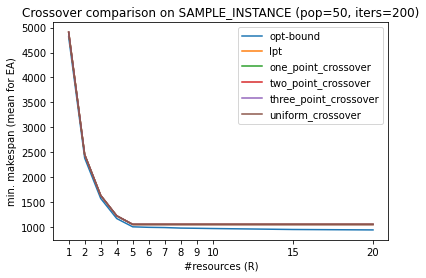

In [8]:
ea_df.plot.line(xticks=resources, xlabel='#resources (R)', ylabel='min. makespan (mean for EA)', title=f'Crossover comparison on SAMPLE_INSTANCE (pop={pop_size}, iters={max_iters})')

## Comparison on sub-optimal instance

<AxesSubplot:title={'center':'LPT on sub-optimal instance'}, xlabel='#resources', ylabel='min. makespan'>

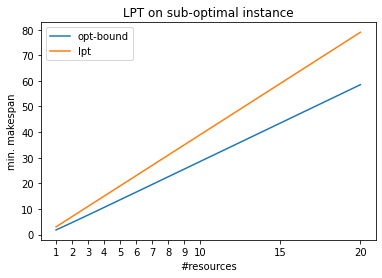

In [9]:
lpt_df = pd.DataFrame(data=(eval_lpt(R, suboptimal_instance) for R in resources), index=resources, columns=['opt-bound', 'lpt'])
lpt_df.plot.line(xticks=resources, xlabel='#resources', ylabel='min. makespan', title='LPT on sub-optimal instance')